# Simulating different scanning arrangements

Simulating the scanning process and using this to develop reconstruction methods. We specify the locations of the emitters (es) and detectors (ds) using polar coordinates where a radius of 1 corresponds to the closer of the two, the circle around which we're scanning. Usually try to keep both at 1, but sometimes it is necessary to move one away further.

In [2]:
import skimage.io
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from skimage.transform import iradon

import seaborn as sns

%matplotlib inline

# Drae a set of emitters and detectors

# Get a point as a pixel location
def point_to_pixel(x, y, w, h):
    xp = int(min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds
    yp = int(min(h-1, (-y*(h/2) + h/2)))
    return xp, yp

# Floating point version (for interpolation methods later)
def point_to_pixelf(x, y, w, h):
    xp = (min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds - a little less accurate but hey
    yp = (min(h-1, (-y*(h/2) + h/2)))
    return xp, yp

def draw_des(ds, es, width, height):

    ## Cairo STUFF

    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, width, height)
    ctx = cairo.Context (surface)

    ctx.set_source_rgb(1,1,1)
    ctx.rectangle(0,0,width,height)
    ctx.fill()

    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)

    ## Back to the good stuff

    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()

    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
#         print(cx, cy)

    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
#         print(cx, cy)
        
    return surface

def draw_des_surf(surface, ds, es, width, height):
    ctx = cairo.Context (surface)
    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)
    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height))
    ctx.stroke()
    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()
    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
        
    return surface

def get_paths(img, ds, es, width, height):
    # Does interpolation along all paths from emitters to detectors, given an image, detectors and emitters
    lines = []
    for e in es:
        for d in ds:
            y0, x0 = point_to_pixel(e['r']*math.cos(e['a']), e['r']*math.sin(e['a']), width, height) # E loc
            y1, x1 = point_to_pixel(d['r']*math.cos(d['a']), d['r']*math.sin(d['a']), width, height) # d loc

            # Make samplng points
            length = int(np.hypot(x1-x0, y1-y0))
            x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

            # Extract the values along the line
            zi = img[x.astype(np.int), y.astype(np.int)]
            lines.append(sum(zi))
    return lines

def test_image(w, h, r, x, y):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    xp, yp = point_to_pixel(x, y, w, h)
#     xp -= r
#     yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.arc(xp, yp, r, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def p1(w, h):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    x, y = 0, 0
    xp, yp = point_to_pixel(x, y, w, h)
#     xp -= r
#     yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.rectangle(xp, yp, w/4, h/4)
    ctx.rectangle(xp-w/4, yp-h/4, w/4, h/4)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def rotate_des(ds, es, angle):
    for d in ds:
        d['a'] += angle
    for e in es:
        e['a'] += angle
    return ds, es

0.5

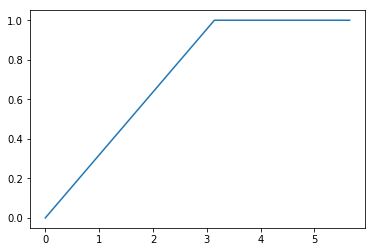

In [3]:
# Defining spread:
spread = interp1d([0, math.pi, math.pi*2],[0, 1, 1])

test = [2*math.pi*i/10 for i in range(10)]
plt.plot(test, spread(test))

spread([math.pi*0.5])[0] # Intensity at angle 0.5pi (linear interpolation. Can add kind='cubic')

[20635, 25204, 23642, 14627, 0, 0, 0, 0]


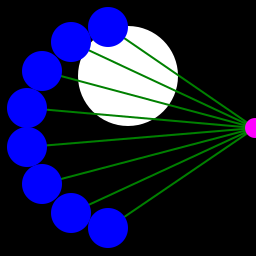

In [4]:
e_spread = interp1d([0, math.pi, math.pi*2],[1, 1, 1])
d_spread = interp1d([0, math.pi, math.pi*2],[1, 1, 1])

e1 = {
    'r':1, # Distance from center relative to furthest object
    'a':0, # Angle in radians
}

es = [e1]
ds = []
for i in range(8):
    d = d1 = {
        'r':0.8, # Distance from center relative to furthest object
        'a':math.pi/2 + math.pi*(i+0.5)/8, #2*math.pi*i/8,
    }
    ds.append(d)
# pd.DataFrame(ds)

tis, tii, x, y = test_image(256, 256, 50, 0, 0.4)
tis.write_to_png('ti.png')
Image('ti.png')

print(get_paths(tii, ds, es, 256, 256))

s = draw_des_surf(tis, ds, es, 256, 256)
s.write_to_png('test.png')
Image('test.png')


        
        

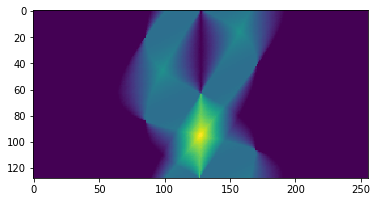

In [5]:
e1 = {
    'r':1, # Distance from center relative to furthest object
    'a':0, # Angle in radians
}

es = [e1]
ds = []
for i in range(256):
    d = d1 = {
        'r':1, # Distance from center relative to furthest object
        'a':2*math.pi*(i+0.5)/256, #2*math.pi*i/8,
    }
    ds.append(d)
    
tis, tii, x, y = p1(256, 256)

paths = []
angles = []
for a in range(128):
    an = math.pi/128
    angles.append(a)
    paths.append(get_paths(tii, *rotate_des(ds, es, an), 256, 256))

plt.imshow(paths)

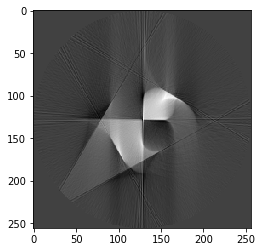

In [6]:
im = iradon(np.asarray(paths).T, theta=[180*(i+0.5)/128 for i in range(128)], circle=True)
plt.imshow(im, cmap=plt.cm.Greys_r)
plt.show()

In [7]:
pa = np.asarray(paths)
pa.shape

(128, 256)

In [8]:
np.asarray(angles).shape

(128,)

(256, 256)


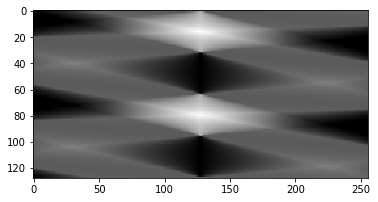

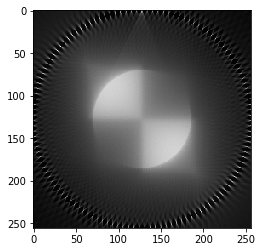

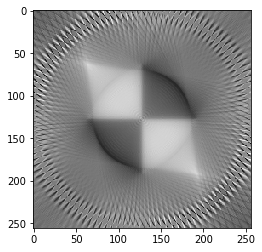

In [9]:
vol_geom = astra.create_vol_geom(256, 256)
angles = np.linspace(0,2*math.pi,128);
proj_geom= astra.create_proj_geom('fanflat', 1, 256, angles, 128, 128);
# geom, detector width, n detectors, projection angles from vertical, dist to emitter, dist to detector plane
# (distances in pixels of the )

# For CPU-based algorithms, a "projector" object specifies the projection
# model used. In this case, we use the "strip" model.
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

# Create a sinogram from a phantom
import scipy.io
P = tii#scipy.io.loadmat('phantom.mat')['phantom256']
print(P.shape)
sinogram_id, sinogram = astra.create_sino(P, proj_id)

[bp_id, bp] = astra.create_backprojection(sinogram, proj_id);

import pylab
pylab.gray()
pylab.figure(1)
pylab.imshow(sinogram)
pylab.figure(2)
pylab.imshow(bp)

# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Available algorithms:
# ART, SART, SIRT, CGLS, FBP


# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 20 iterations of the algorithm
# This will have a runtime in the order of 10 seconds.
astra.algorithm.run(alg_id, 20)

# Get the result
rec = astra.data2d.get(rec_id)
pylab.figure(3)
pylab.imshow(rec)
pylab.show()

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

[255, 255, 510, 1020, 1020, 1530, 2040, 2295, 2295, 2805, 2805, 3315, 3570, 3825, 4080, 4590, 4845, 5355, 5610, 6375, 6375, 6630, 7140, 7905, 7905, 8160, 8670, 9435, 9435, 10200, 10710, 11220, 11730, 11730, 12240, 13005, 13005, 14280, 14790, 14790, 15300, 15555, 16830, 16830, 17085, 17085, 17085, 17085, 17085, 17085, 17085, 17085, 17085, 17085, 16830, 16830, 16830, 16830, 16830, 16830, 16830, 16830, 16830, 16830, 16830, 16830, 16830, 16830, 16830, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16575, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16320, 16

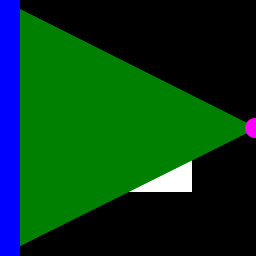

In [10]:
e1 = {
    'r':1, # Distance from center relative to furthest object
    'a':0, # Angle in radians
}

es = [e1]
ds = []
for i in range(256):
    d = d1 = {
        'r':(1+((i-128)/128)**2)**0.5, # Distance from center relative to furthest object
        'a':math.pi+math.atan((i-128)/128)
    }
    ds.append(d)
    

tis, tii, x, y = p1(256, 256)
tis.write_to_png('ti.png')
Image('ti.png')

print(get_paths(tii, ds, es, 256, 256))

s = draw_des_surf(tis, ds, es, 256, 256)
s.write_to_png('test.png')
Image('test.png')



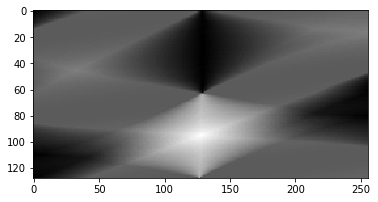

In [11]:
tis, tii, x, y = p1(256, 256)

paths = []
angles = []
for a in range(128):
    an = math.pi/128
    angles.append(a)
    paths.append(get_paths(tii, *rotate_des(ds, es, an), 256, 256))

plt.imshow(paths)

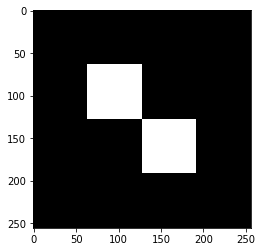

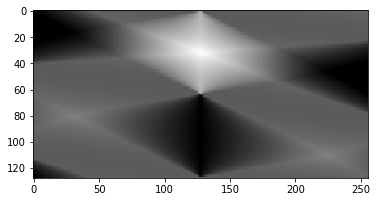

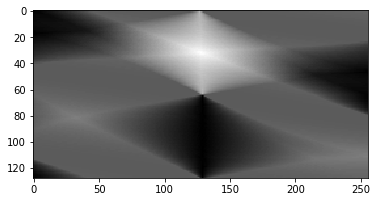

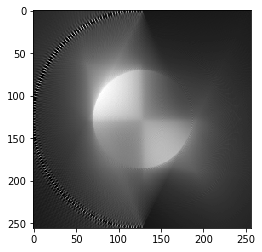

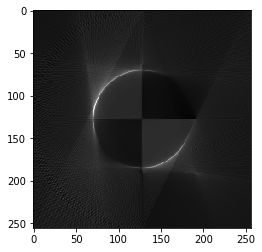

In [14]:
vol_geom = astra.create_vol_geom(256, 256)
angles = np.linspace(0,math.pi,128);
proj_geom= astra.create_proj_geom('fanflat', 1, 256, angles, 128, 128);
# geom, detector width, n detectors, projection angles from vertical, dist to emitter, dist to detector plane
# (distances in pixels of the )

# For CPU-based algorithms, a "projector" object specifies the projection
# model used. In this case, we use the "strip" model.
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

# Create a sinogram from a phantom
import scipy.io
P = tii#scipy.io.loadmat('phantom.mat')['phantom256']
sinogram_id, sinogram = astra.create_sino(P, proj_id)


import pylab
pylab.gray()
pylab.figure(1)
pylab.imshow(P)
pylab.figure(2)
pylab.imshow(sinogram)

s = np.asarray(paths)[::-1]
[bp_id, bp] = astra.create_backprojection(s, proj_id);

pylab.figure(3)
pylab.imshow(s)
pylab.figure(4)
pylab.imshow(bp)

# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict('FBP')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Available algorithms:
# ART, SART, SIRT, CGLS, FBP


# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 20 iterations of the algorithm
# This will have a runtime in the order of 10 seconds.
astra.algorithm.run(alg_id, 4)

# Get the result
rec = astra.data2d.get(rec_id)
pylab.figure(5)
pylab.imshow(rec)
pylab.show()

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

In [15]:
sinogram[0][:10]

array([ 142.99672,  431.70953,  724.1274 , 1020.3485 , 1320.4739 ,
       1624.6083 , 1932.8596 , 2245.3398 , 2562.1633 , 2883.4512 ],
      dtype=float32)

In [16]:
s[0][:10]

array([ 510,  510,  510,  765, 1275, 1530, 2040, 2040, 2295, 2805])

# Going from a ring of detectors to a plane

To match the closest thing we can get in astra, we need to go from an arrangement like A to one like B. To do this, we project the readings onto a plane and then interpolate.

[0, 0, 6161, 24009, 24070, 7399, 0, 0]


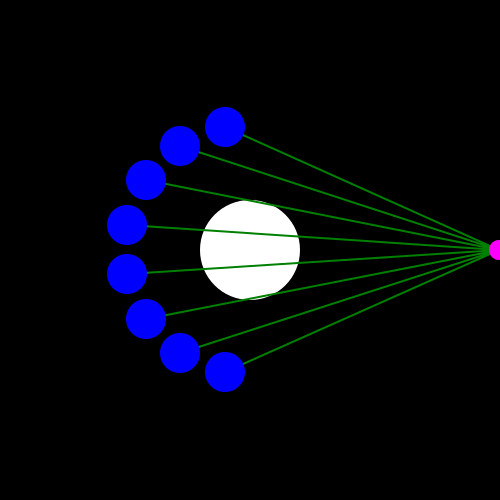

In [17]:
e1 = {
    'r':1, # Distance from center relative to furthest object
    'a':0, # Angle in radians
}

es = [e1]
ds = []
for i in range(8):
    d = d1 = {
        'r':0.5, # Distance from center relative to furthest object
        'a':math.pi/2 + math.pi*(i+0.5)/8, #2*math.pi*i/8,
    }
    ds.append(d)



tis, tii, x, y = test_image(500, 500, 50, 0, 0)
print(get_paths(tii, ds, es, 500, 500))
s = draw_des_surf(tis, ds, es, 500, 500)
s.write_to_png('test.png')
Image('test.png')



[0, 0, 9851, 24171, 24169, 10213, 0, 0]


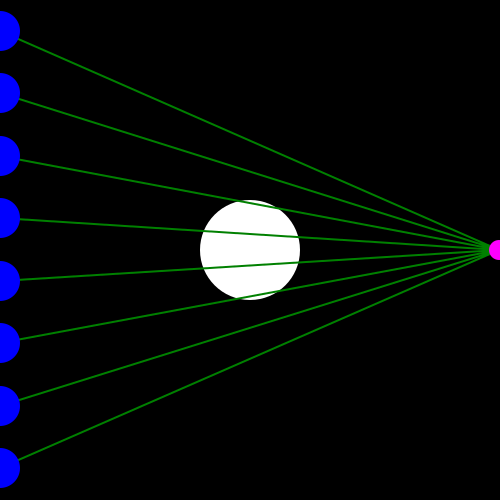

In [18]:
e1 = {
    'r':1, # Distance from center relative to furthest object
    'a':0, # Angle in radians
}

es = [e1]
ds = []
for i in range(8):
    d = {
        'r':(1+(((i+0.5)*32-128)/128)**2)**0.5, # Distance from center relative to furthest object
        'a':math.pi+math.atan(((i+0.5)*32-128)/128)
    }
    ds.append(d)


tis, tii, x, y = test_image(500, 500, 50, 0, 0)

print(get_paths(tii, ds, es, 500, 500))

s = draw_des_surf(tis, ds, es, 500, 500)
s.write_to_png('test.png')
Image('test.png')

Installing astra

Before running pip install, I needed to install build-essential (automake and autoconf) and python3-dev and sudo apt-get install libboost-all-dev 
sudo apt-get install libtool m4 automake


In [ ]:
# -----------------------------------------------------------------------
# Copyright: 2010-2018, imec Vision Lab, University of Antwerp
#            2013-2018, CWI, Amsterdam
#
# Contact: astra@astra-toolbox.com
# Website: http://www.astra-toolbox.com/
#
# This file is part of the ASTRA Toolbox.
#
#
# The ASTRA Toolbox is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# The ASTRA Toolbox is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with the ASTRA Toolbox. If not, see <http://www.gnu.org/licenses/>.
#
# -----------------------------------------------------------------------

import astra
import numpy as np

vol_geom = astra.create_vol_geom(256, 256)
proj_geom = astra.create_proj_geom('parallel', 1.0, 384, np.linspace(0,np.pi,180,False))

# For CPU-based algorithms, a "projector" object specifies the projection
# model used. In this case, we use the "strip" model.
proj_id = astra.create_projector('strip', proj_geom, vol_geom)

# Create a sinogram from a phantom
import scipy.io
P = scipy.io.loadmat('phantom.mat')['phantom256']
sinogram_id, sinogram = astra.create_sino(P, proj_id)

import pylab
pylab.gray()
pylab.figure(1)
pylab.imshow(P)
pylab.figure(2)
pylab.imshow(sinogram)

# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Available algorithms:
# ART, SART, SIRT, CGLS, FBP


# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 20 iterations of the algorithm
# This will have a runtime in the order of 10 seconds.
astra.algorithm.run(alg_id, 20)

# Get the result
rec = astra.data2d.get(rec_id)
pylab.figure(3)
pylab.imshow(rec)
pylab.show()

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)


In [ ]:
# -----------------------------------------------------------------------
# Copyright: 2010-2018, imec Vision Lab, University of Antwerp
#            2013-2018, CWI, Amsterdam
#
# Contact: astra@astra-toolbox.com
# Website: http://www.astra-toolbox.com/
#
# This file is part of the ASTRA Toolbox.
#
#
# The ASTRA Toolbox is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# The ASTRA Toolbox is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with the ASTRA Toolbox. If not, see <http://www.gnu.org/licenses/>.
#
# -----------------------------------------------------------------------

import astra
import numpy as np

vol_geom = astra.create_vol_geom(256, 256)
#proj_geom = astra.create_proj_geom('parallel', 1.0, 384, np.linspace(0,np.pi,180,False))
angles = np.linspace(0,2*math.pi,360);
proj_geom= astra.create_proj_geom('fanflat', 2, 256, angles, 128, 128);

# geom, detector width, n detectors, projection angles from vertical, dist to emitter, dist to detector plane

# For CPU-based algorithms, a "projector" object specifies the projection
# model used. In this case, we use the "strip" model.
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

# Create a sinogram from a phantom
import scipy.io
P = scipy.io.loadmat('phantom.mat')['phantom256']
sinogram_id, sinogram = astra.create_sino(P, proj_id)

[bp_id, bp] = astra.create_backprojection(sinogram, proj_id);

import pylab
pylab.gray()
pylab.figure(1)
pylab.imshow(P)
pylab.figure(2)
pylab.imshow(bp)

# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Available algorithms:
# ART, SART, SIRT, CGLS, FBP


# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 20 iterations of the algorithm
# This will have a runtime in the order of 10 seconds.
astra.algorithm.run(alg_id, 20)

# Get the result
rec = astra.data2d.get(rec_id)
pylab.figure(3)
pylab.imshow(rec)
pylab.show()

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

In [ ]:
# -----------------------------------------------------------------------
# Copyright: 2010-2018, imec Vision Lab, University of Antwerp
#            2013-2018, CWI, Amsterdam
#
# Contact: astra@astra-toolbox.com
# Website: http://www.astra-toolbox.com/
#
# This file is part of the ASTRA Toolbox.
#
#
# The ASTRA Toolbox is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# The ASTRA Toolbox is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with the ASTRA Toolbox. If not, see <http://www.gnu.org/licenses/>.
#
# -----------------------------------------------------------------------

import astra
import numpy as np

vol_geom = astra.create_vol_geom(256, 256)
#proj_geom = astra.create_proj_geom('parallel', 1.0, 384, np.linspace(0,np.pi,180,False))
angles = np.linspace(0,2*math.pi,360);
proj_geom= astra.create_proj_geom('fanflat', 2, 456, angles, 228, 228);

# geom, detector width, n detectors, projection angles from vertical, dist to emitter, dist to detector plane

# For CPU-based algorithms, a "projector" object specifies the projection
# model used. In this case, we use the "strip" model.
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

# Create a sinogram from a phantom
import scipy.io
P = scipy.io.loadmat('phantom.mat')['phantom256']
sinogram_id, sinogram = astra.create_sino(P, proj_id)

[bp_id, bp] = astra.create_backprojection(sinogram, proj_id);

import pylab
pylab.gray()
pylab.figure(1)
pylab.imshow(P)
pylab.figure(2)
pylab.imshow(bp)

# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Available algorithms:
# ART, SART, SIRT, CGLS, FBP


# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 20 iterations of the algorithm
# This will have a runtime in the order of 10 seconds.
astra.algorithm.run(alg_id, 20)

# Get the result
rec = astra.data2d.get(rec_id)
pylab.figure(3)
pylab.imshow(rec)
pylab.show()

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)